# Churn Prediction - Telecom Case
Author: Daniel Grzebyk

Date: 1.07.2022

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

## Loading the data

In [3]:
df = pd.read_csv("data/telecom/data.csv")
var_df = pd.read_csv("data/telecom/variables-definition.csv")

X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

## Exploratory Data Analysis (EDA)
Research Question: Why customers leave the company?

Hypothesis to be verified:
- the services are too expensive - if yes, then lower income households would leave more frequently, as they are more price-sensitive
- the services are not required - if yes, few calls, low data usage, etc.
- low quality of service - many calls failed due to network issues
- geography: maybe in some geographical areas (lower network coverage or income)
- are household with children more loyal customers?

Relevant Observations:
- Data Structure: every row is a customer / household
- Problem: binary classification problem: predict whether a customer will stay with the telecom company or leave
- Label: churn - the number of customers leaving

Interesting features
- Failed calls might indicate issues with the quality of service. What % of all calls fails, and how does it influence customer loyalty?
- Time spent calling customer service, happy customers rarely call.

Features not relevant for predicting churn:
- Number and minutes of unanswered and received calls
- Whether calls are wireless or not
- Network traffic, whether call is peak or off-peak
- The number of call participants
- Whether calls are incoming or outbound
- Distinction between voice and data calls

In [26]:
features_eliminated = ['Customer_ID', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean',
                       'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
                       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 
                       'mou_cdat_Mean', 'mou_rvce_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean',
                       'callwait_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean',
                       'cc_mou_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'roam_Mean',
                       'ethnic']

df.drop(columns=features_eliminated, inplace=True)

# Knowing number of calls and their mean time, average time per call can be calculated

In [28]:
df.shape

(100000, 66)

Why the months are not normally distributed? The distribution is right-skewed. The longest staying customer is with the company for 5 years. Peak around 12th month might indicate past sale or a marketing campaign.

<AxesSubplot:xlabel='months', ylabel='Count'>

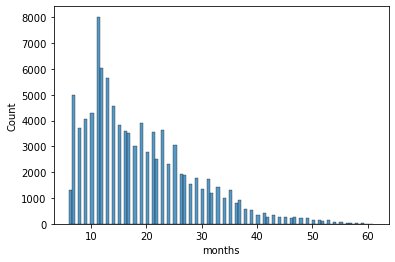

In [29]:
sns.histplot(df['months'])

As customer requirements are covered by multiple products, in order to check which customers significantly changed their consumption it is the easiest to look at the revenue they bring. It can be seen that around 5% of all customers reduced their spending by at least 50% with respect to the 3 month mean. These customers might be the potential leavers.

After identifying who the potential leavers might be, it will be checked what % of revenue they bring to the company. E.g. suddent outflow of high-revenue clients could be a source of a major concern.

In [48]:
rapid_reduction_rate = round(len(df['change_rev'].loc[df['change_rev'] < -50]) / len(df), 2)
rapid_reduction_rate

0.05

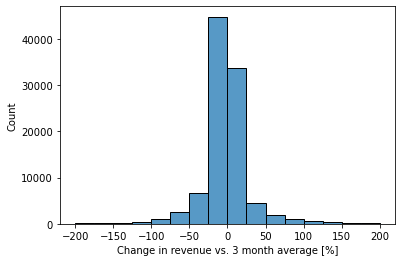

In [69]:
sns.histplot(df['change_rev'], binrange=(-200, 200), binwidth=25)
plt.xlabel("Change in revenue vs. 3 month average [%]")
plt.show()

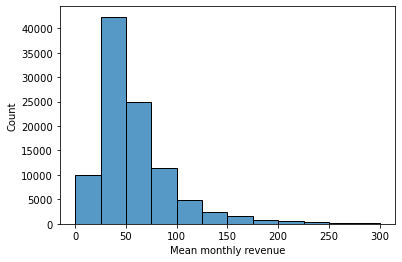

In [67]:
sns.histplot(df['rev_Mean'], binrange=(0,300), binwidth=25)
plt.xlabel("Mean monthly revenue")
plt.show()

Customers who use more than they declared in their plan often bear additional costs. Are these costs the reason why they change the service provider? Probably not, as they are usually less than 10% of the overall costs.

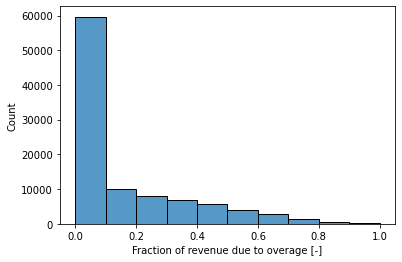

In [92]:
df['overrev_ratio'] = df['ovrrev_Mean'] / df['rev_Mean']
sns.histplot(df['overrev_ratio'], binrange=(0, 1), binwidth=0.1)
plt.xlabel("Fraction of revenue due to overage [-]")
plt.show()

Is the drop in consumption correlated with the costs of the service for the customer?

(0.0, 1000.0)

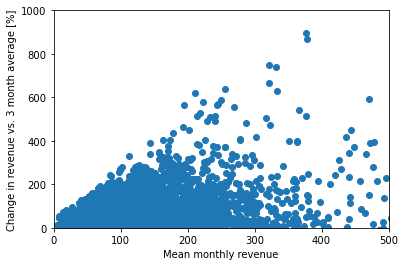

In [74]:
plt.scatter(data=df, x='rev_Mean', y='change_rev')
plt.xlabel("Mean monthly revenue")
plt.ylabel("Change in revenue vs. 3 month average [%]")
plt.xlim([0, 500])
plt.ylim([0, 1000])

Clients' income is a categorical variable, but no information about the brackets for each class were provided. It is assumed that income will be the most influencial of all status-related features including also: size of dwelling, credit card information, number of cars, etc. 

In [59]:
df['income'].value_counts()

6.0    18802
7.0    11597
9.0    10833
5.0     8277
4.0     7790
3.0     5830
8.0     5142
1.0     4033
2.0     2260
Name: income, dtype: int64

How many households have children, and are households with children more loyal customers? The initial hypothesis is the parents of young children are too busy to make changes in telecom providers, but this tendency is expected to disappear as children are older.

<AxesSubplot:xlabel='totmrc_Mean', ylabel='Count'>

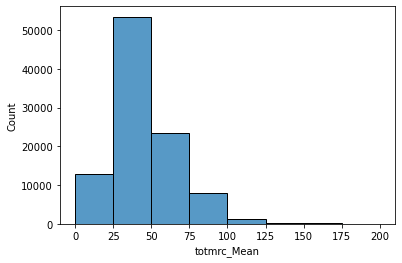

In [25]:
sns.histplot(df['totmrc_Mean'], binrange=(0, 200), binwidth=25)

Clearly, there are very few customers who pay for the service and not use it. Therefore, rapid drop of demand might be correlated with churn.

<AxesSubplot:xlabel='actsubs_ratio', ylabel='Count'>

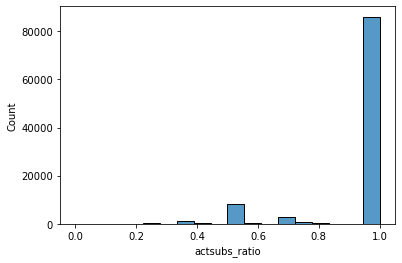

In [64]:
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
sns.histplot(df['actsubs_ratio'])

## Data Preprocessing
### Looking for duplicates

In [7]:
X.duplicated().sum()

0

### Dropping useless columns

In [8]:
X.drop(columns=['Customer_ID'], inplace=True)

### Dropping NaNs

In [13]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 20000]  # Is one of the dropped features crucial?

ownrent     33706
lor         30190
dwlltype    31909
adults      23019
infobase    22079
income      25436
numbcars    49366
HHstatin    37923
dwllsize    38308
dtype: int64

In [18]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 20000].index)  # drop features which have more than 20% NaNs
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['ownrent', 'lor', 'dwlltype', 'adults', 'infobase', 'income', 'numbcars', 'HHstatin', 'dwllsize']
Before dropping rows with NaNs: (100000, 89)
After dropping rows with NaNs: (78334, 89)


### Identifying numerical, categorical, text features

In [4]:
X.select_dtypes(include='number').columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs',
       'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou',
       'adjqty', 'avgrev', 'avgmou', 'av

In [5]:
X.select_dtypes(include='object').columns

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

In [6]:
X.select_dtypes(include='category').columns

Index([], dtype='object')

In [19]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

In [20]:
len(num_features) + len(cat_features)

89

In [21]:
len(cols_to_drop)

9

### Looking for correlations

In [22]:
num_features

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs',
       'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou',
       'adjqty', 'avgrev', 'avgmou', 'av

<AxesSubplot:>

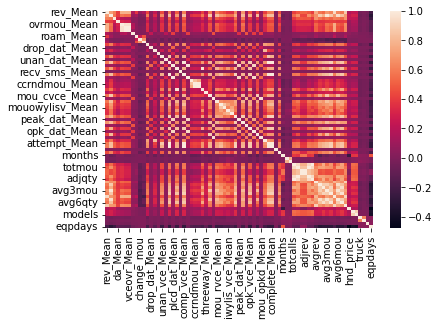

In [23]:
corr = df[num_features].corr()
sns.heatmap(corr)

### Looking for class imbalance

In [25]:
y.value_counts()

0    40360
1    37974
Name: churn, dtype: int64

## Predicting churn

### Splitting the data

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# For simplicity I am skipping the test (left-out) set, I would prefer to use 60%-20%-20% data split

### Training the model

In [27]:
# I did not identify text features
ct = make_column_transformer((StandardScaler(), num_features),
                             (OneHotEncoder(handle_unknown='ignore'), cat_features),
                             n_jobs=-1,
                             verbose=True)

pipeline = Pipeline(
    steps=[("preprocessor", ct), ("regressor", LogisticRegression(max_iter=100))]
)

# Training the model
pipeline.fit(X_train, y_train)

C:\Users\danie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean...
       'truck', 'rv', 'forgntvl', 'eqpdays'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'marital', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10',

In [28]:
# Train Inference
y_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

In [29]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 0.59
Train Precision: 0.59
Train Recall: 0.55

Validation Accuracy: 0.6
Validation Precision: 0.59
Validation Recall: 0.56


## Error Analysis / Postprocessing

## Cusomer segmentation

In [54]:
# 1. Use Elbow method to find the number of distinct customer groups
# 2. For every cluster separately check the % of leavers
data

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,forgntvl,eqpdays
0,23.997500,219.250000,22.500,0.2475,0.000000,0.000000,0.000000,0.0,0.00,-157.250000,...,322.0,136.0,38.0,149.98999,2.0,2.0,0.0,0.0,0.0,361.0
4,55.230000,570.500000,71.980,0.0000,0.000000,0.000000,0.000000,0.0,0.00,38.500000,...,586.0,196.0,80.0,149.98999,6.0,4.0,0.0,0.0,0.0,434.0
5,82.275000,1312.250000,75.000,1.2375,0.000000,0.000000,0.000000,0.0,0.00,156.750000,...,1187.0,853.0,78.0,129.98999,9.0,4.0,0.0,0.0,0.0,458.0
9,31.662500,25.500000,29.990,0.2475,0.000000,0.000000,0.000000,0.0,0.00,59.500000,...,54.0,7.0,34.0,79.98999,2.0,2.0,0.0,0.0,1.0,601.0
10,62.127500,97.500000,65.985,2.4750,0.000000,0.000000,0.000000,0.0,0.00,23.500000,...,123.0,32.0,64.0,79.98999,3.0,3.0,0.0,0.0,0.0,464.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99973,0.000000,76.000000,29.670,0.0000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,...,85.0,38.0,33.0,29.98999,1.0,1.0,0.0,0.0,0.0,883.0
99976,31.923333,63.333333,16.990,0.0000,42.666667,14.933333,14.933333,0.0,0.00,-38.333333,...,46.0,22.0,28.0,29.98999,1.0,1.0,0.0,0.0,0.0,883.0
99981,34.990000,6.333333,44.990,0.0000,0.000000,0.000000,0.000000,0.0,0.00,-6.333333,...,203.0,39.0,37.0,99.98999,3.0,3.0,0.0,0.0,0.0,118.0
99986,117.490000,384.000000,29.990,0.0000,250.000000,87.500000,87.500000,0.0,0.00,0.000000,...,135.0,106.0,34.0,59.98999,2.0,2.0,0.0,0.0,0.0,489.0


In [57]:
%%time
distorsions = []

data = X[num_features].copy()

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distorsions.append(kmeans.inertia_)

Wall time: 2min 40s


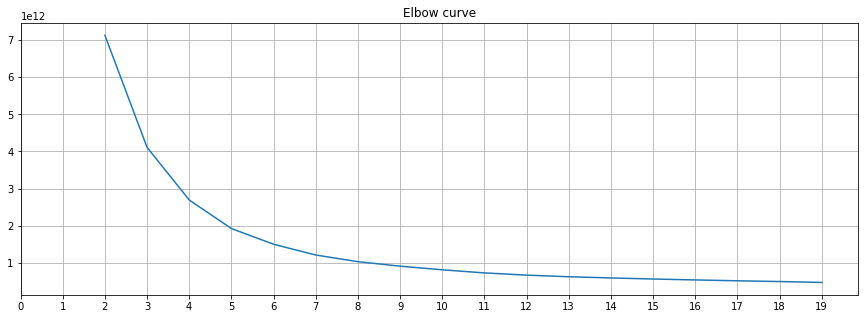

In [61]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)
plt.title('Elbow curve')
plt.show()

Using the Elbow Method I identify the optimal number of clusters to be 5 and retrain KMeans on it.

What does this information give me? What if the elbow method identifies 100 clusters? How will it help me identify churners? I cannot investigate 100 clusters manually.

PCA is not an option, because it loses variance.

In [62]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(data)

KMeans(n_clusters=5)

In [65]:
data['cluster_no'] = kmeans.labels_

In [ ]:
plt.scatter()